In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
epoch = 3

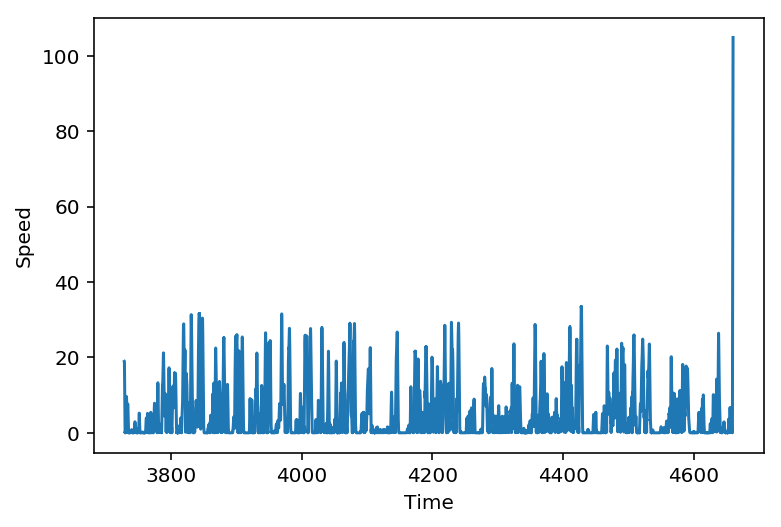

In [161]:
from scipy.io import loadmat
from replay_identification.state_transition import estimate_indicator_probability

epoch = 2
linpos = loadmat('../Raw-Data/Bond/bonlinpos03.mat')['linpos'][:, -1][0][:, epoch - 1][0][0]['statematrix'][0]
vel = np.abs(linpos['linearVelocity'][0, 0][:, 0])
vel_time = linpos['time'][0, 0].squeeze()
ripples = loadmat('../Raw-Data/Bond/bonripplescons03.mat')
ripple_start = ripples['ripplescons'][0, -1][0, epoch - 1][0, 0]['starttime'][0, 0].squeeze()
ripple_end = ripples['ripplescons'][0, -1][0, epoch - 1][0, 0]['endtime'][0, 0].squeeze()

plt.plot(vel_time, vel);
plt.xlabel('Time')
plt.ylabel('Speed');

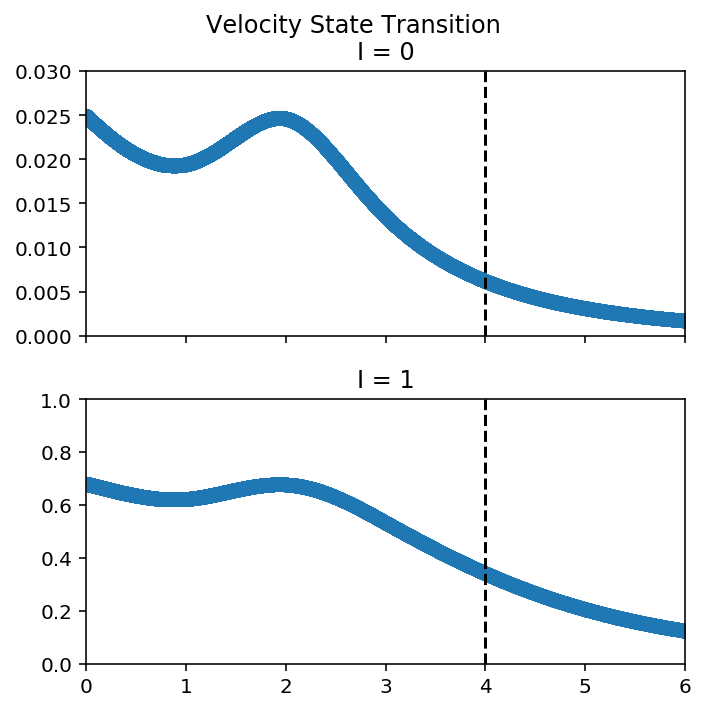

In [226]:
from scipy.interpolate import interp1d

is_replay = np.zeros_like(vel_time, dtype=bool)
    
for start, end in zip(ripple_start, ripple_end):
    ripple_ind = (vel_time >= start) & (vel_time <= end)
    is_replay[ripple_ind] = (np.max(vel[ripple_ind]) <= 4)
    
probability_I = estimate_indicator_probability(vel, is_replay, penalty=1E-5)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
ax[0].scatter(vel[:-1], probability_I[1:, 0])
ax[0].axvline(4, color='black', linestyle='--')
ax[0].set_title('I = 0')
ax[0].set_ylim((0, 0.03))

ax[1].scatter(vel[:-1], probability_I[1:, 1])
ax[1].axvline(4, color='black', linestyle='--')
ax[1].set_title('I = 1');
ax[1].set_ylim((0, 1))

plt.xlim((0, 6));
plt.suptitle('Velocity State Transition')
plt.tight_layout()
plt.subplots_adjust(top=0.90)

/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:168: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


(0, 6)

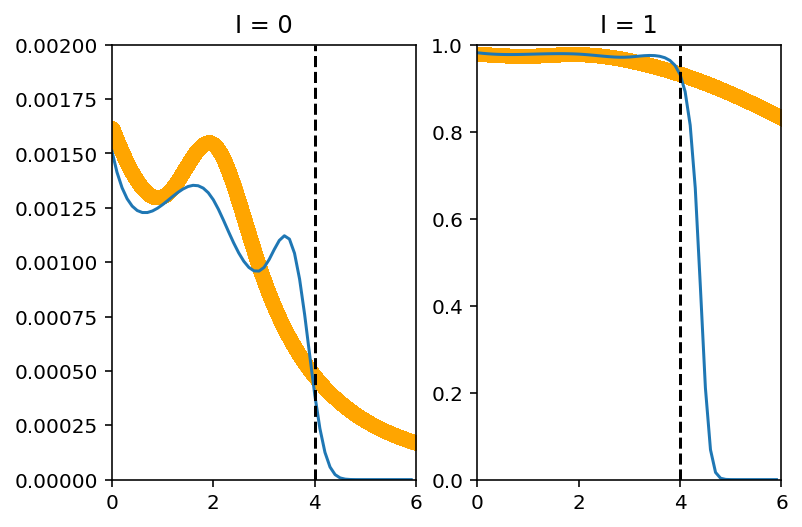

In [258]:
import numpy as np
from statsmodels.api import GLM, families
from patsy import build_design_matrices, dmatrices
from scipy.stats import norm

from scipy.interpolate import interp1d
new_sampling_frequency = 500
n_interpolated_time_samples = (np.floor(np.ptp(vel_time) * new_sampling_frequency) + 1).astype(int)
new_time = np.min(vel_time) + np.arange(n_interpolated_time_samples) / new_sampling_frequency
interpolated_velocity = interp1d(vel_time, vel)(new_time)

is_replay_interpolated = np.zeros_like(new_time, dtype=bool)
    
for start, end in zip(ripple_start, ripple_end):
    ripple_ind = (new_time >= start) & (new_time <= end)
#     is_replay_interpolated[ripple_ind] = True
    is_replay_interpolated[ripple_ind] = (np.max(interpolated_velocity[ripple_ind]) <= 4)
    
## write.csv(data.frame(vel_1, I, time_vel_1), 'interpolated_velocity.csv')
# long_vel = pd.read_csv('../interpolated_velocity.csv').drop('Unnamed: 0', axis=1)
# new_time = long_vel.time_vel_1.values
# interpolated_velocity = long_vel.vel_1.values
# is_replay_interpolated = long_vel.I.values

probability_I = estimate_indicator_probability(interpolated_velocity, is_replay_interpolated)

data = {
    'is_replay': is_replay_interpolated[1:].astype(float),
    'lagged_is_replay': is_replay_interpolated[:-1].astype(float),
    'lagged_speed': interpolated_velocity[:-1]
}
MODEL_FORMULA = (
    'is_replay ~ 1 + lagged_is_replay + '
    'bs(lagged_speed, knots=[1, 2, 3, 20])')
response, design_matrix = dmatrices(MODEL_FORMULA, data)
family = families.Binomial()
model = GLM(response, design_matrix, family=family)
fit = model.fit()

fig, axes = plt.subplots(1, 2)

s = np.arange(0, 6, .1)
predict_data = {
    'lagged_is_replay': 0 * np.ones_like(s),
    'lagged_speed': s
}
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

probability = fit.predict(predict_design_matrix)
axes[0].plot(s, probability)
axes[0].scatter(interpolated_velocity[:-1], probability_I[1:, 0], alpha=0.3, color='orange')
axes[0].axvline(4, color='black', linestyle='--')
axes[0].set_title('I = 0')
axes[0].set_ylim((0, 0.002))
axes[0].set_xlim((0, 6))

predict_data = {
    'lagged_is_replay': 1 * np.ones_like(s),
    'lagged_speed': s
}
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

probability = fit.predict(predict_design_matrix)
axes[1].plot(s, probability)
axes[1].scatter(interpolated_velocity[:-1], probability_I[1:, 1], alpha=0.3, color='orange')
axes[1].axvline(4, color='black', linestyle='--')
axes[1].set_title('I = 1');
axes[1].set_ylim((0, 1))
axes[1].set_xlim((0, 6))


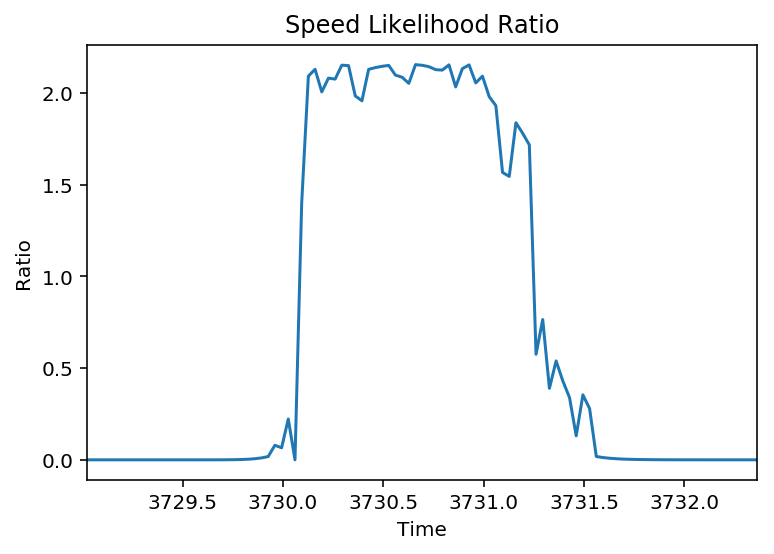

In [179]:
from replay_identification.speed_likelhood import estimate_speed_likelihood_ratio

speed_likelihood_ratio = estimate_speed_likelihood_ratio(vel, is_replay, speed_threshold=4)
plt.plot(vel_time, speed_likelihood_ratio)
plt.xlim((vel_time[0], vel_time[100]))
plt.title('Speed Likelihood Ratio')
plt.xlabel('Time')
plt.ylabel('Ratio');

array([-179.94,  180.  ])

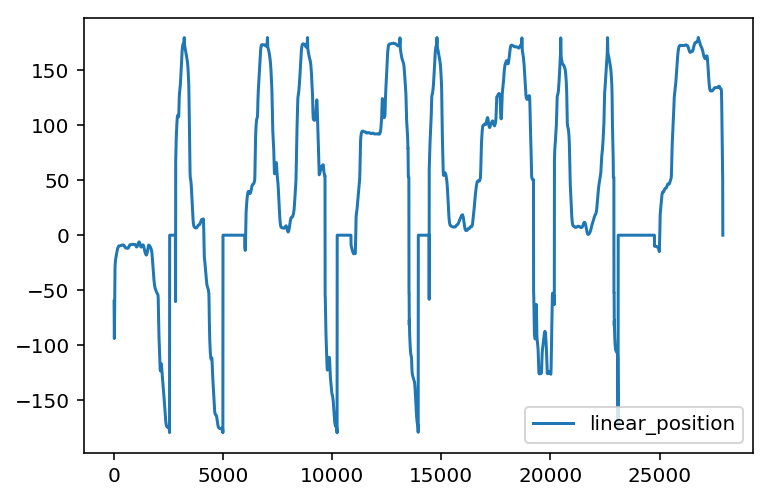

In [230]:
import pandas as pd
linear_position = pd.read_table('../Raw-Data/Bond/bond0302.dat',
                                header=None, names=['linear_position']) * 60
linear_position[linear_position > 360] = 360
linear_position[linear_position < -360] = -360
linear_position[np.abs(linear_position) > 180] = (linear_position[np.abs(linear_position) > 180] > 0) * (360 - np.abs(linear_position[np.abs(linear_position) > 180]))
linear_position.plot()
np.percentile(linear_position, [0, 100])

In [231]:
from statsmodels.api import GLM, families
from patsy import build_design_matrices, dmatrices

speed_threshold = vel[1:] > 4

data = {
    'position': linear_position.values[1:][speed_threshold],
    'lagged_position': linear_position.values[:-1][speed_threshold]
}
MODEL_FORMULA = 'position ~ lagged_position - 1'
response, design_matrix = dmatrices(MODEL_FORMULA, data)
fit = GLM(response, design_matrix, family=families.Gaussian()).fit()

sigma_30 = np.sqrt(np.sum(fit.resid_response ** 2) / fit.df_resid)
alpha_30 = fit.params[0]

Transfer to new frequency rate, 500 Hz.

In [232]:
old_sampling_frequency = 30
new_sampling_frequency = 500
sped_up_factor = 20
sped_up_sampling_frequency = new_sampling_frequency / sped_up_factor

def transfer_to_new_sampling_frequency(alpha_old, sigma_old, old_sampling_frequency, new_sampling_frequency):
    alpha_new = (alpha_old ** old_sampling_frequency) ** (1 / new_sampling_frequency)
    sigma_new = np.sqrt((1 - alpha_new ** 2) *
                        (1 - alpha_old ** (old_sampling_frequency * 2)) /
                        (1 - alpha_old ** 2) /
                        (1 - alpha_new ** (new_sampling_frequency * 2))
                       ) * sigma_old
    return sigma_new

sigma_500 = transfer_to_new_sampling_frequency(alpha_30, sigma_30, old_sampling_frequency, new_sampling_frequency)
sigma_sped_up = transfer_to_new_sampling_frequency(
    alpha_30, sigma_30, old_sampling_frequency, sped_up_sampling_frequency) # sigma_25

In [233]:
from scipy.stats import norm
    
def create_position_state_transition(place_bins, position, sigma):
    '''Zero mean random walk with covariance based on movement
    
    p(x_{k} | x_{k-1}, I_{k}, I_{k-1})
    '''
    position_bin_size = np.diff(place_bins)[0]
    state_transition_matrix = norm.pdf(
        place_bins[:, np.newaxis], loc=place_bins[np.newaxis, :],
        scale=sigma)
    state_transition_matrix /= np.sum(
        state_transition_matrix, axis=0, keepdims=True) * position_bin_size
    
    return state_transition_matrix

position_bin_size = 1

place_bins = np.arange(min(linear_position.values), max(linear_position.values), position_bin_size)
position_state_transition = create_position_state_transition(place_bins, linear_position.values, sigma_500)
position_state_transition_sped_up = create_position_state_transition(place_bins, linear_position.values, sigma_30)

In [319]:
n_time = n_interpolated_time_samples.copy()
n_place_bins = place_bins.size
place_bin_size = np.diff(place_bins)[0]

posterior_density = np.zeros((n_time,))
q1_x = np.zeros((n_place_bins, n_time))
uniform = np.ones((n_place_bins,)) / n_place_bins
likelihood = np.zeros_like(q1_x)

for time_ind in np.arange(1, n_time):
    lfp_ind = time_ind % 10
    prior1 = (probability_I[time_ind, 1] * (position_state_transition_sped_up.dot(q1_x[:, time_ind - 1])) +
              probability_I[time_ind, 0] * (1 - posterior_density[time_ind - 1]) * uniform
             )
    likelihood[:, time_ind] = (speed_likelihood_ratio[time_ind] *
                         LFP_likelihood_ratio[(time_ind % 10) * (lfp_ind == 0)] *
                         spiking_likelihood_ratio[time_ind])
    updated_posterior = likelihood[:, time_ind] * prior1
    q0 = ((1 - probability_I[time_ind - 1, 0]) * (1 - posterior_density[time_ind - 1]) +
          (1 - probability_I[time_ind - 1, 1]) * posterior_density[time_ind - 1]
    )
    s = np.sum(updated_posterior * place_bin_size / n_place_bins)
    norm = s + q0
    posterior_density[time_ind] = s / norm
    q1_x[:, time_ind] = updated_posterior / norm
    

NameError: name 'LFP_likelihood_ratio' is not defined

In [ ]:
vel_idx <- 0  # whether we consider p(v_t|v_{t-1}, I_t)
# integrate information form multiple sources, with multiple time scale
posterior_density <- numeric(n_time)  # posterior density
uniform <- rep(1 / n_place_bins, n_place_bins)

n_place_bins <- length(x_grid)  # x_grid is the discrete grid in linear space, 1:180 (or 1:200) for example
q1_x <- matrix(0, n_place_bins, n_time)  # replay period, joint with hidden state x
q0 <- numeric(0)  # non-replay period
for (time_ind in 2:(n_time)) {
  # do this since the LFP information comes in every 20 ms, 10 times slower than
  # spiking information
  idx <- time_ind %% 10
  # the sum and integral calculation, calculating one-step prediction density
  prior1 <- (
    p_I_1[time_ind] * (x_transition_1 %*% q1_x[, time_ind - 1] * place_bin_size) +
    p_I_0[time_ind] * (1 - posterior_density[time_ind - 1]) * uniform)
  p_deltaN_1 <- log(Lambda) %*% N_spiking[, time_ind] - rowSums(Lambda)
  log_likelihood_spiking <- p_deltaN_1 - p_deltaN_0[time_ind]

  q1_x[, time_ind] <- (
    exp(log_likelihood_LFP[time_ind %/% 10 + 1] * (idx == 0)) *
    exp(log_likelihood_velocity[time_ind - 1] * vel_idx) *
    exp(log_likelihood_spiking) *
    prior1)
  q0 <- ( (1 - p_I_0[time_ind - 1]) * (1 - posterior_density[time_ind - 1]) +
          (1 - p_I_1[time_ind - 1]) * posterior_density[time_ind - 1])
  s <- sum(q1_x[, time_ind] * place_bin_size / n_place_bins)
  norm < - s + q0
  posterior_density[time_ind] <- s / norm
   # normalize q1_x
  q1_x[, time_ind] <- q1_x[, time_ind] / norm
}
summary(posterior_density)